## Task-2: Exploratory Data Analysis
### Objective: Analyze the data to understand patterns and factors influencing financial inclusion in Ethiopia

In [12]:
# Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Load datasets
df = pd.read_csv("../data/processed/ethiopia_fi_unified_data_enriched.csv")
impact_df = pd.read_csv("../data/processed/impact_links_enriched.csv")

print(f"Dataset loaded: {len(df)} records")
print(f"Impact links loaded: {len(impact_df)} records")
print(f"Record types: {df['record_type'].unique().tolist()}")


Dataset loaded: 47 records
Impact links loaded: 16 records
Record types: ['observation', 'target', 'event']


---
## 1. Dataset Overview

In [13]:
# 1.1 Record Type Distribution
print("=" * 60)
print("1. DATASET OVERVIEW SUMMARY")
print("=" * 60)

print(f"\nTotal Records: {len(df)}")
print("\n--- Record Type Distribution ---")
record_type_counts = df['record_type'].value_counts()
print(record_type_counts)

obs_df = df[df['record_type'] == 'observation']
pillar_counts = obs_df['pillar'].value_counts()
print("\n--- Pillar Distribution (Observations) ---")
print(pillar_counts)

source_counts = df['source_type'].value_counts()
print("\n--- Source Type Distribution ---")
print(source_counts)


1. DATASET OVERVIEW SUMMARY

Total Records: 47

--- Record Type Distribution ---
record_type
observation    32
event          12
target          3
Name: count, dtype: int64

--- Pillar Distribution (Observations) ---
pillar
ACCESS           15
USAGE            12
GENDER            4
AFFORDABILITY     1
Name: count, dtype: int64

--- Source Type Distribution ---
source_type
operator      15
survey        10
regulator      8
research       4
policy         4
calculated     2
news           2
secondary      1
government     1
Name: count, dtype: int64


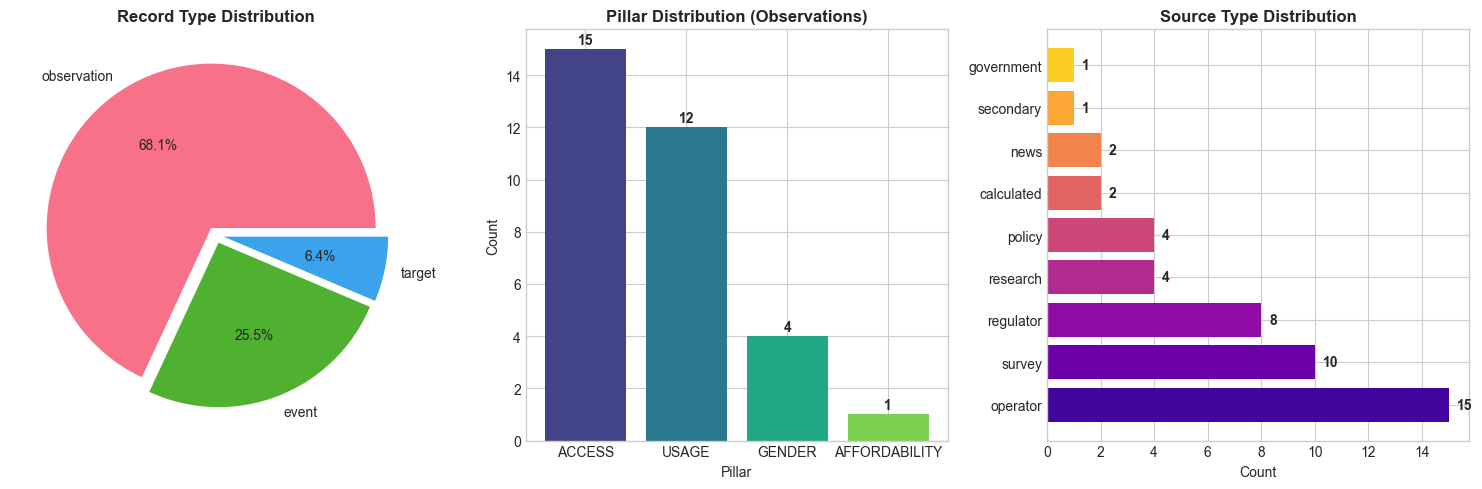


Figure saved: reports/figures/01_dataset_overview.png


In [14]:
# 1.2 Create Overview Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Record Type Pie Chart
axes[0].pie(record_type_counts.values, labels=record_type_counts.index, autopct='%1.1f%%', 
            colors=sns.color_palette("husl", len(record_type_counts)), explode=[0.05]*len(record_type_counts))
axes[0].set_title('Record Type Distribution', fontsize=12, fontweight='bold')

# Pillar Distribution (Observations)
axes[1].bar(pillar_counts.index, pillar_counts.values, color=sns.color_palette("viridis", len(pillar_counts)))
axes[1].set_title('Pillar Distribution (Observations)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Pillar')
axes[1].set_ylabel('Count')
for i, v in enumerate(pillar_counts.values):
    axes[1].text(i, v + 0.2, str(v), ha='center', fontweight='bold')

# Source Type Distribution
axes[2].barh(source_counts.index, source_counts.values, color=sns.color_palette("plasma", len(source_counts)))
axes[2].set_title('Source Type Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Count')
for i, v in enumerate(source_counts.values):
    axes[2].text(v + 0.3, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/01_dataset_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved: reports/figures/01_dataset_overview.png")


---
## 2. Temporal Coverage Analysis

In [15]:
# 2.1 Temporal Range Analysis
print("=" * 60)
print("2. TEMPORAL COVERAGE ANALYSIS")
print("=" * 60)

# Convert observation_date to datetime
df['observation_date'] = pd.to_datetime(df['observation_date'])
df['year'] = df['observation_date'].dt.year

print(f"\nTemporal Range: {df['observation_date'].min()} to {df['observation_date'].max()}")
print(f"Total time span: {(df['observation_date'].max() - df['observation_date'].min()).days // 365} years")

# Records by Year
print("\n--- Records by Year ---")
yearly_counts = df.groupby(['year', 'record_type']).size().unstack(fill_value=0)
print(yearly_counts)


2. TEMPORAL COVERAGE ANALYSIS

Temporal Range: 2014-12-31 00:00:00 to 2030-12-31 00:00:00
Total time span: 16 years

--- Records by Year ---
record_type  event  observation  target
year                                   
2014             0            1       0
2017             0            1       0
2021             2            5       0
2022             2            0       0
2023             2            2       0
2024             3           12       0
2025             3           11       1
2028             0            0       1
2030             0            0       1


#### change observations_date to datetime 

In [27]:
df['observation_date'] = pd.to_datetime(
    df['observation_date'],
    errors='coerce'  # invalid dates → NaT instead of crashing
)


In [29]:
obs_df = df[df['record_type'] == 'observation'].copy()

In [30]:
print(obs_df['observation_date'].dtype)


datetime64[us]


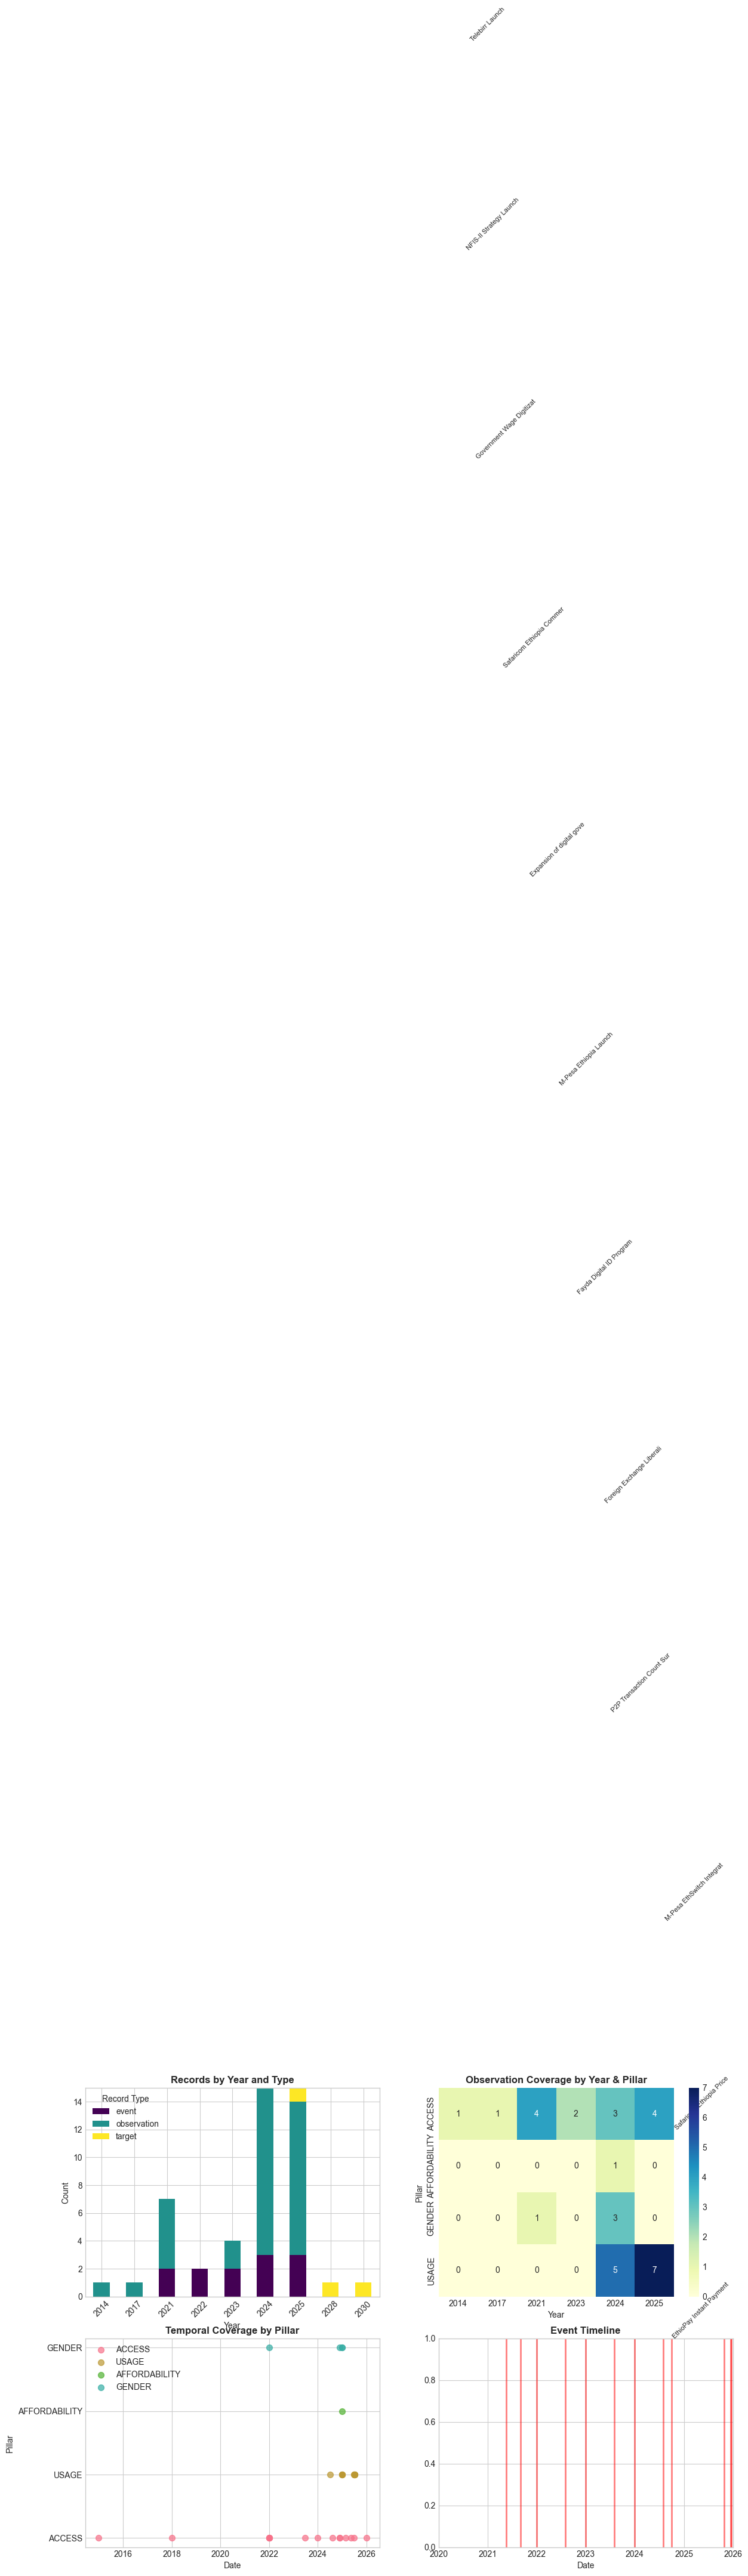


Figure saved: reports/figures/02_temporal_coverage.png


In [48]:
# 2.2 Temporal Coverage Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Records by Year (stacked bar)
yearly_counts.plot(kind='bar', stacked=True, ax=axes[0, 0], colormap='viridis')
axes[0, 0].set_title('Records by Year and Type', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend(title='Record Type')
axes[0, 0].tick_params(axis='x', rotation=45)

# Pillar coverage by year (heatmap)
obs_by_year_pillar = obs_df.groupby([obs_df['observation_date'].dt.year, 'pillar']).size().unstack(fill_value=0)
sns.heatmap(obs_by_year_pillar.T, annot=True, fmt='d', cmap='YlGnBu', ax=axes[0, 1])
axes[0, 1].set_title('Observation Coverage by Year & Pillar', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Pillar')

# Timeline of all observations by pillar
for pillar in obs_df['pillar'].dropna().unique():
    pillar_data = obs_df[obs_df['pillar'] == pillar]
    axes[1, 0].scatter(pillar_data['observation_date'], [pillar] * len(pillar_data), 
                      label=pillar, s=50, alpha=0.7)
axes[1, 0].set_title('Temporal Coverage by Pillar', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Pillar')
axes[1, 0].legend(loc='upper left')
axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Event timeline
events_df = df[df['record_type'] == 'event'].copy()
events_df = events_df[events_df['observation_date'].notna()]
events_df = events_df.sort_values('observation_date')
for i, (_, event) in enumerate(events_df.iterrows()):
    axes[1, 1].axvline(x=event['observation_date'], color='red', alpha=0.5, linewidth=2)
    event_name = str(event['indicator'])[:25] if pd.notna(event['indicator']) else 'Unknown'
    axes[1, 1].text(event['observation_date'], len(events_df) - i, event_name, fontsize=8, rotation=45, ha='right')
axes[1, 1].set_title('Event Timeline', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_xlim([pd.Timestamp('2020-01-01'), pd.Timestamp('2026-01-01')])

plt.tight_layout()
plt.savefig('../reports/figures/02_temporal_coverage.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved: reports/figures/02_temporal_coverage.png")


---
## 3. Data Quality Assessment

In [33]:
# 3.1 Confidence Level Distribution
print("=" * 60)
print("3. DATA QUALITY ASSESSMENT")
print("=" * 60)

print("\n--- Confidence Level Distribution ---")
confidence_counts = df['confidence'].value_counts()
print(confidence_counts)

print(f"\n--- Missing Data Analysis ---")
missing_pct = (df.isnull().sum() / len(df) * 100).round(1)
missing_cols = missing_pct[missing_pct > 0].sort_values(ascending=False)
print("Columns with missing data (>0%):")
print(missing_cols.head(10))


3. DATA QUALITY ASSESSMENT

--- Confidence Level Distribution ---
confidence
high      40
medium     7
Name: count, dtype: int64

--- Missing Data Analysis ---
Columns with missing data (>0%):
impact_estimate      100.0
lag_months           100.0
evidence_basis       100.0
impact_magnitude     100.0
related_indicator    100.0
relationship_type    100.0
impact_direction     100.0
region               100.0
parent_id            100.0
notes                 91.5
dtype: float64


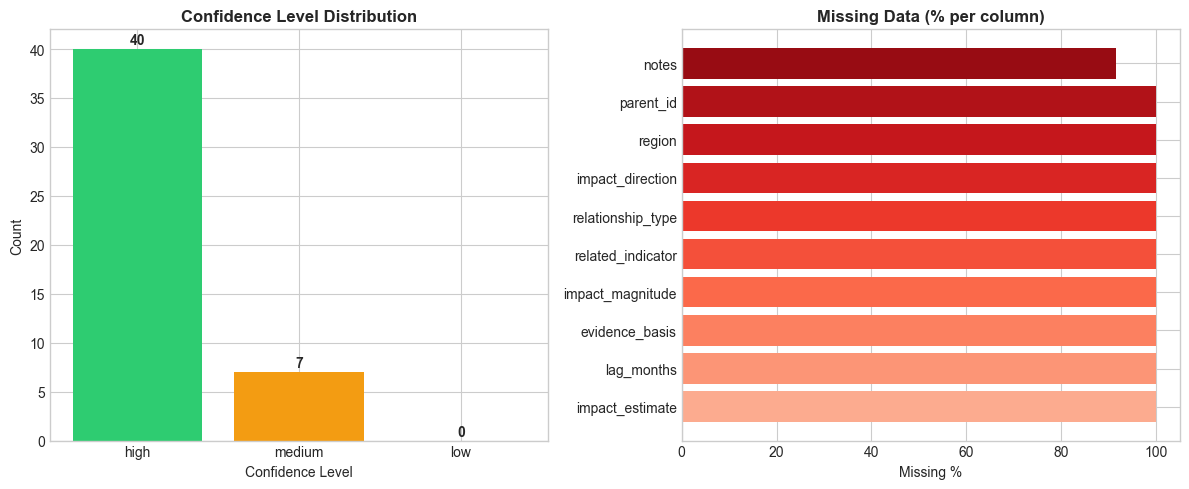


Figure saved: reports/figures/03_data_quality.png


In [34]:
# 3.2 Data Quality Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confidence Distribution
colors_conf = {'high': '#2ecc71', 'medium': '#f39c12', 'low': '#e74c3c'}
conf_order = ['high', 'medium', 'low']
conf_data = [confidence_counts.get(c, 0) for c in conf_order]
axes[0].bar(conf_order, conf_data, color=[colors_conf.get(c, 'gray') for c in conf_order])
axes[0].set_title('Confidence Level Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Confidence Level')
axes[0].set_ylabel('Count')
for i, v in enumerate(conf_data):
    axes[0].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Missing Data (top 10 columns)
top_missing = missing_cols.head(10)
colors_missing = plt.cm.Reds(np.linspace(0.3, 0.9, len(top_missing)))
axes[1].barh(top_missing.index, top_missing.values, color=colors_missing)
axes[1].set_title('Missing Data (% per column)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Missing %')

plt.tight_layout()
plt.savefig('../reports/figures/03_data_quality.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved: reports/figures/03_data_quality.png")


---
## 4. Data Gaps Identification

In [35]:
# 4.1 Identify Data Gaps
print("=" * 60)
print("4. DATA GAPS IDENTIFICATION")
print("=" * 60)

# Check indicator coverage
print("\n--- Indicator Coverage by Pillar ---")
indicator_coverage = obs_df.groupby('pillar')['indicator_code'].nunique()
print(indicator_coverage)

# Single observation indicators
print("\n--- Indicators with Single Observation ---")
indicator_counts = obs_df.groupby('indicator_code').size()
single_obs = indicator_counts[indicator_counts == 1]
print(f"Count: {len(single_obs)}")
print(f"Indicators: {single_obs.index.tolist()}")

# Key indicators temporal gaps
print("\n--- Temporal Gaps in Key Indicators ---")
key_indicators = ['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT', 'USG_P2P_COUNT']
for ind in key_indicators:
    ind_data = obs_df[obs_df['indicator_code'] == ind]
    if len(ind_data) > 0:
        years = ind_data['observation_date'].dt.year.sort_values().tolist()
        print(f"{ind}: {years}")


4. DATA GAPS IDENTIFICATION

--- Indicator Coverage by Pillar ---
pillar
ACCESS            5
AFFORDABILITY     1
GENDER            3
USAGE            11
Name: indicator_code, dtype: int64

--- Indicators with Single Observation ---
Count: 14
Indicators: ['ACC_MOBILE_PEN', 'AFF_DATA_INCOME', 'GEN_GAP_MOBILE', 'GEN_MM_SHARE', 'USG_ACTIVE_RATE', 'USG_ATM_COUNT', 'USG_ATM_VALUE', 'USG_CROSSOVER', 'USG_G2P_DIGITIZED', 'USG_MPESA_ACTIVE', 'USG_MPESA_USERS', 'USG_P2P_VALUE', 'USG_TELEBIRR_USERS', 'USG_TELEBIRR_VALUE']

--- Temporal Gaps in Key Indicators ---
ACC_OWNERSHIP: [2014, 2017, 2021, 2021, 2021, 2024]
ACC_MM_ACCOUNT: [2021, 2024]
USG_P2P_COUNT: [2024, 2025]


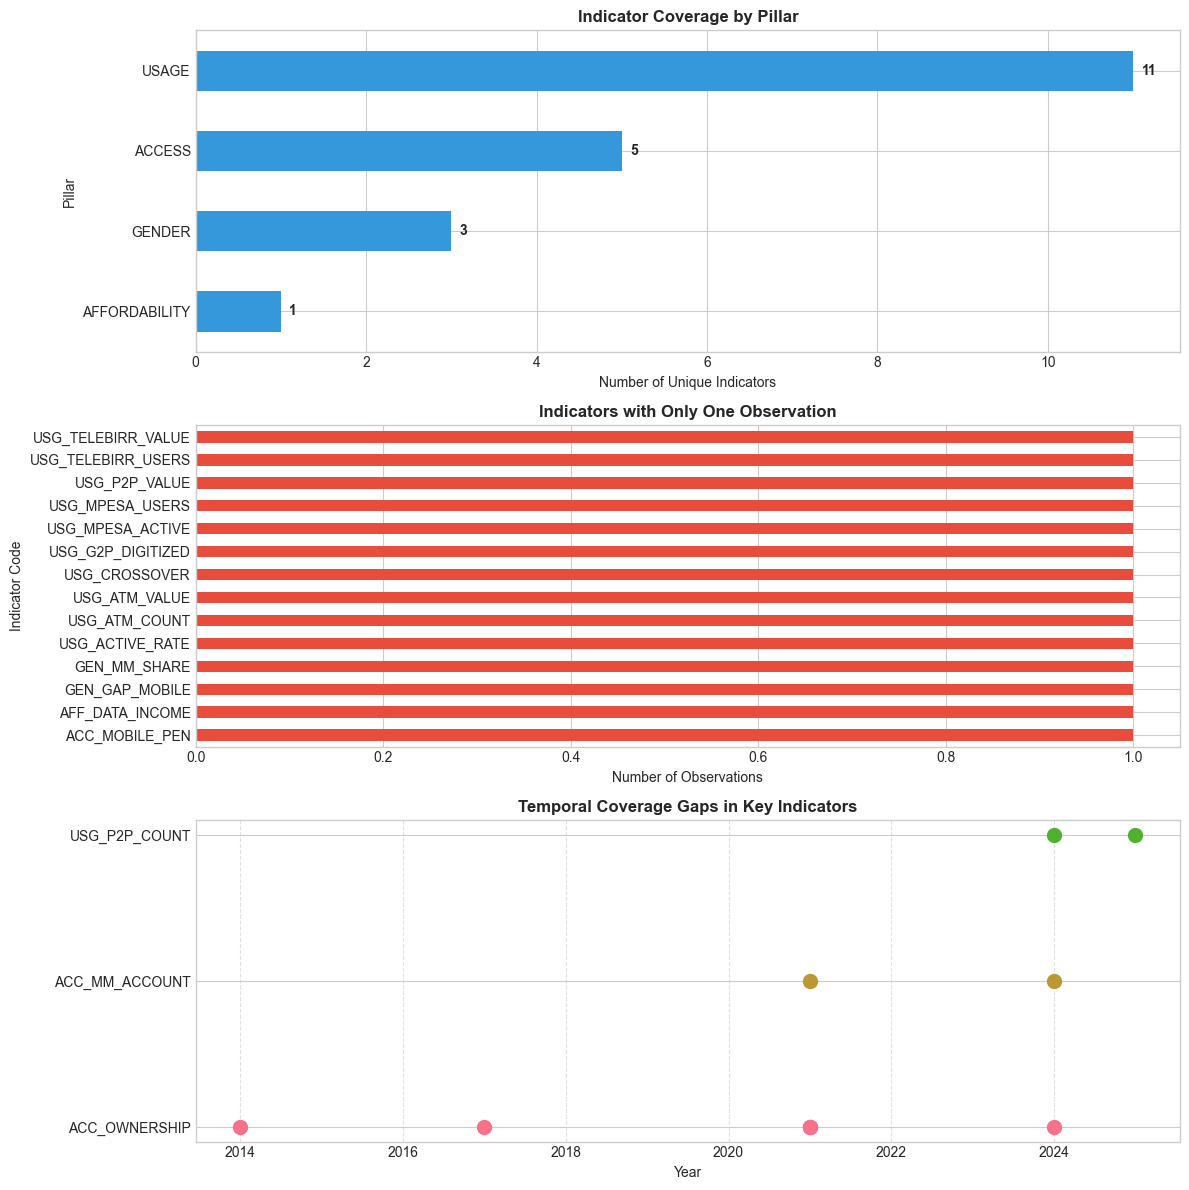

In [64]:
import matplotlib.pyplot as plt

# Prepare data
key_indicators = ['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT', 'USG_P2P_COUNT']
indicator_coverage = obs_df.groupby('pillar')['indicator_code'].nunique()
indicator_counts = obs_df.groupby('indicator_code').size()
single_obs = indicator_counts[indicator_counts == 1]

# Create subplots (3 axes vertically)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)

# --- 1. Indicator Coverage by Pillar ---
indicator_coverage.sort_values().plot(kind='barh', ax=axes[0], color='#3498db')
axes[0].set_title('Indicator Coverage by Pillar', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Unique Indicators')
axes[0].set_ylabel('Pillar')
for i, v in enumerate(indicator_coverage.sort_values()):
    axes[0].text(v + 0.1, i, str(v), va='center', fontweight='bold')

# --- 2. Indicators with Single Observation ---
single_obs.sort_values().plot(kind='barh', ax=axes[1], color='#e74c3c')
axes[1].set_title('Indicators with Only One Observation', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Observations')
axes[1].set_ylabel('Indicator Code')

# --- 3. Temporal Gaps in Key Indicators ---
for y, ind in enumerate(key_indicators):
    ind_data = obs_df[obs_df['indicator_code'] == ind]
    years = ind_data['observation_date'].dt.year.tolist()
    axes[2].scatter(years, [y] * len(years), s=100)
axes[2].set_yticks(range(len(key_indicators)))
axes[2].set_yticklabels(key_indicators)
axes[2].set_xlabel('Year')
axes[2].set_title('Temporal Coverage Gaps in Key Indicators', fontsize=12, fontweight='bold')
axes[2].grid(axis='x', linestyle='--', alpha=0.6)

# Save & show
plt.tight_layout()
plt.savefig('../reports/figures/03_data_gaps_combined.png', dpi=150)
plt.show()


---
## 5. Access Analysis

In [36]:
# 5.1 Account Ownership Trajectory
print("=" * 60)
print("5. ACCESS ANALYSIS")
print("=" * 60)

# Get account ownership data (overall only)
acc_ownership = obs_df[(obs_df['indicator_code'] == 'ACC_OWNERSHIP') & (obs_df['gender'] == 'all')].copy()
acc_ownership = acc_ownership.sort_values('observation_date')

print("\n--- Account Ownership Trajectory (2014-2024) ---")
for _, row in acc_ownership.iterrows():
    print(f"{row['observation_date'].strftime('%Y')}: {row['value_numeric']}%")

# Calculate growth rates
years = acc_ownership['observation_date'].dt.year.values
values = acc_ownership['value_numeric'].values

print("\n--- Growth Analysis ---")
print(f"2014-2017 Growth: {values[1] - values[0]:.0f} pp ({(values[1]/values[0] - 1)*100:.1f}%)")
print(f"2017-2021 Growth: {values[2] - values[1]:.0f} pp ({(values[2]/values[1] - 1)*100:.1f}%)")
print(f"2021-2024 Growth: {values[3] - values[2]:.0f} pp ({(values[3]/values[2] - 1)*100:.1f}%)")

total_growth = values[-1] - values[0]
cagr = ((values[-1]/values[0])**(1/(years[-1]-years[0])) - 1) * 100
print(f"\nTotal Growth (2014-2024): {total_growth:.0f} pp")
print(f"CAGR: {cagr:.1f}%")


5. ACCESS ANALYSIS

--- Account Ownership Trajectory (2014-2024) ---
2014: 22.0%
2017: 35.0%
2021: 46.0%
2024: 49.0%

--- Growth Analysis ---
2014-2017 Growth: 13 pp (59.1%)
2017-2021 Growth: 11 pp (31.4%)
2021-2024 Growth: 3 pp (6.5%)

Total Growth (2014-2024): 27 pp
CAGR: 8.3%


In [37]:
# 5.2 Gender Gap Analysis
print("\n--- Gender Gap Analysis ---")

# Get gender-disaggregated data
gender_acc = obs_df[(obs_df['indicator_code'] == 'ACC_OWNERSHIP') & 
                      (obs_df['gender'].isin(['male', 'female']))]
gender_pivot = gender_acc.pivot_table(index='observation_date', 
                                       columns='gender', 
                                       values='value_numeric',
                                       aggfunc='first')
gender_pivot['gap'] = gender_pivot['male'] - gender_pivot['female']
print(gender_pivot)

# Mobile Money Account Gender Gap
mm_gender = obs_df[(obs_df['indicator_code'] == 'ACC_MM_ACCOUNT')]
print(f"\n--- Mobile Money Account Rate ---")
print(f"2021: {mm_gender[mm_gender['observation_date'].dt.year == 2021]['value_numeric'].values[0]:.1f}%")
print(f"2024: {mm_gender[mm_gender['observation_date'].dt.year == 2024]['value_numeric'].values[0]:.1f}%")



--- Gender Gap Analysis ---
gender            female  male   gap
observation_date                    
2021-12-31          36.0  56.0  20.0

--- Mobile Money Account Rate ---
2021: 4.7%
2024: 9.4%


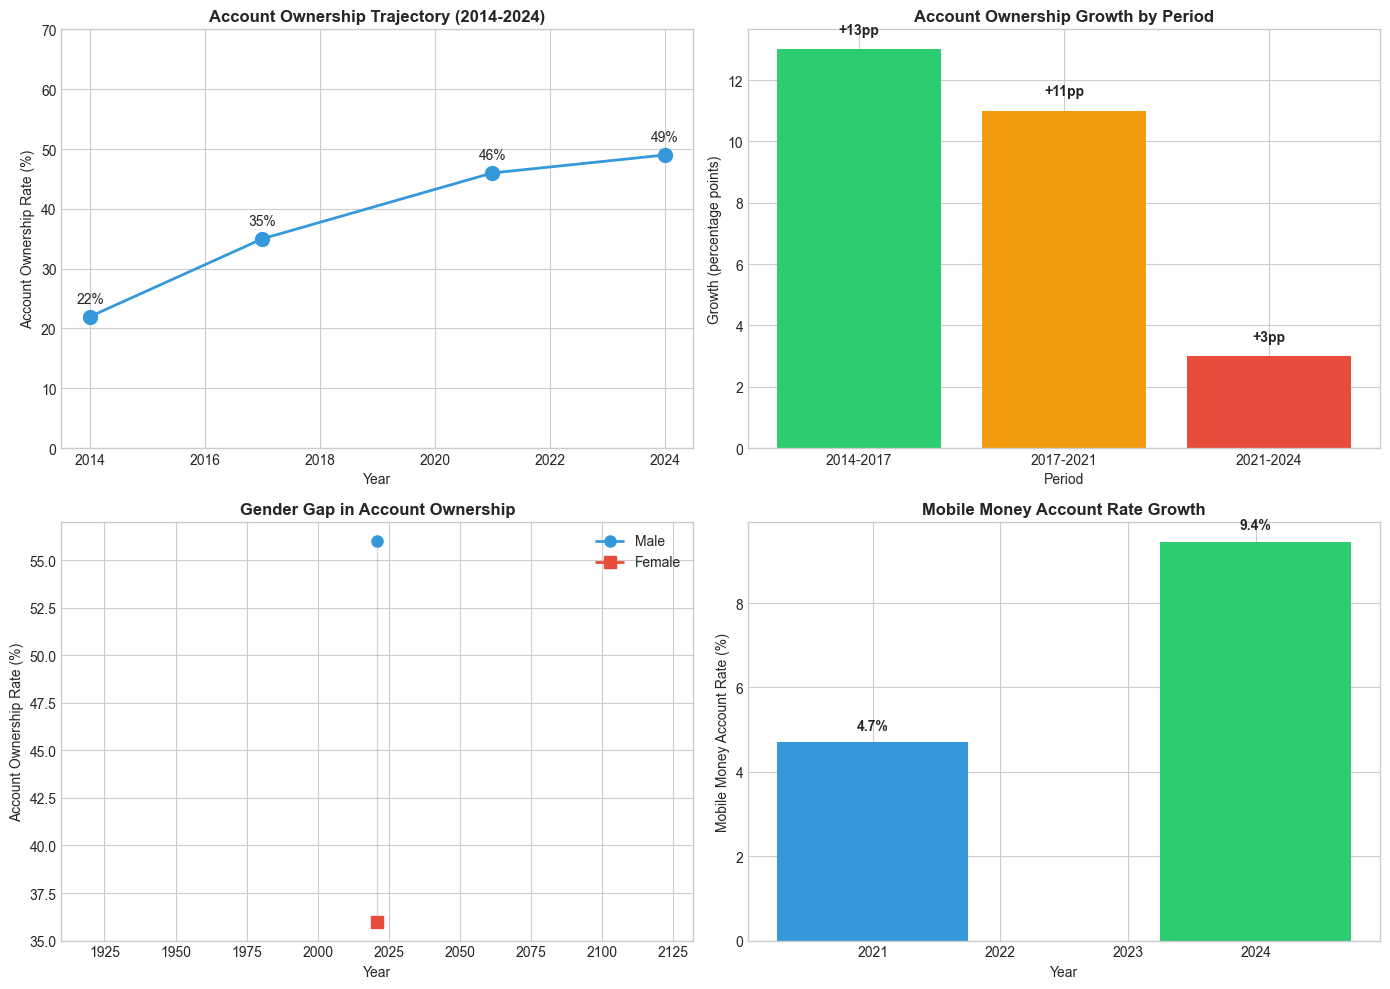


Figure saved: reports/figures/04_access_analysis.png


In [41]:
# 5.3 Access Analysis Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Account Ownership Trajectory
ax1 = axes[0, 0]
years_plot = acc_ownership['observation_date'].dt.year
ax1.plot(years_plot, acc_ownership['value_numeric'], 'o-', linewidth=2, markersize=10, color='#3498db')
ax1.set_title('Account Ownership Trajectory (2014-2024)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Account Ownership Rate (%)')
ax1.set_ylim([0, 70])
for i, (x, y) in enumerate(zip(years_plot, acc_ownership['value_numeric'])):
    ax1.annotate(f'{y:.0f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Growth Rate by Period
ax2 = axes[0, 1]
periods = ['2014-2017', '2017-2021', '2021-2024']
growth_rates = [values[1] - values[0], values[2] - values[1], values[3] - values[2]]
colors_growth = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax2.bar(periods, growth_rates, color=colors_growth)
ax2.set_title('Account Ownership Growth by Period', fontsize=12, fontweight='bold')
ax2.set_xlabel('Period')
ax2.set_ylabel('Growth (percentage points)')
for bar, rate in zip(bars, growth_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'+{rate:.0f}pp', ha='center', fontweight='bold')

# Gender Gap Over Time
ax3 = axes[1, 0]
gender_years = gender_pivot.index.year
ax3.plot(gender_years, gender_pivot['male'], 'o-', label='Male', linewidth=2, markersize=8, color='#3498db')
ax3.plot(gender_years, gender_pivot['female'], 's-', label='Female', linewidth=2, markersize=8, color='#e74c3c')
ax3.fill_between(gender_years, gender_pivot['female'], gender_pivot['male'], alpha=0.3, color='gray')
ax3.set_title('Gender Gap in Account Ownership', fontsize=12, fontweight='bold')
ax3.set_xlabel('Year')
ax3.set_ylabel('Account Ownership Rate (%)')
ax3.legend()

# Mobile Money Account Growth
ax4 = axes[1, 1]
mm_years = [2021, 2024]
mm_values = [4.7, 9.45]
ax4.bar(mm_years, mm_values, color=['#3498db', '#2ecc71'], width=1.5)
ax4.set_title('Mobile Money Account Rate Growth', fontsize=12, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Mobile Money Account Rate (%)')
for i, (y, v) in enumerate(zip(mm_years, mm_values)):
    ax4.text(y, v + 0.3, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/04_access_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved: reports/figures/04_access_analysis.png")


---
## 6. Usage Analysis

In [42]:
# 6.1 Mobile Money Penetration Analysis
print("=" * 60)
print("6. USAGE ANALYSIS")
print("=" * 60)

# Telebirr Users
telebirr = obs_df[obs_df['indicator_code'] == 'USG_TELEBIRR_USERS'].sort_values('observation_date')
print("\n--- Telebirr Registered Users ---")
for _, row in telebirr.iterrows():
    print(f"{row['observation_date'].strftime('%Y-%m-%d')}: {row['value_numeric']/1e6:.1f}M users")

# M-Pesa Users
mpesa = obs_df[obs_df['indicator_code'] == 'USG_MPESA_USERS']
print(f"\n--- M-Pesa Registered Users (Dec 2024) ---")
print(f"Registered: {mpesa['value_numeric'].values[0]/1e6:.1f}M users")

mpesa_active = obs_df[obs_df['indicator_code'] == 'USG_MPESA_ACTIVE']['value_numeric'].values[0]
print(f"90-Day Active: {mpesa_active/1e6:.1f}M users")
print(f"Activity Rate: {mpesa_active/mpesa['value_numeric'].values[0]*100:.0f}%")

# Combined mobile money accounts
telebirr_latest = telebirr['value_numeric'].values[-1] if len(telebirr) > 0 else 0
mpesa_registered = mpesa['value_numeric'].values[0] if len(mpesa) > 0 else 0
print(f"\n--- Combined Mobile Money Accounts ---")
print(f"Telebirr: {telebirr_latest/1e6:.1f}M")
print(f"M-Pesa: {mpesa_registered/1e6:.1f}M")
print(f"Total: {(telebirr_latest + mpesa_registered)/1e6:.1f}M registered accounts")


6. USAGE ANALYSIS

--- Telebirr Registered Users ---
2025-06-30: 54.8M users

--- M-Pesa Registered Users (Dec 2024) ---
Registered: 10.8M users
90-Day Active: 7.1M users
Activity Rate: 66%

--- Combined Mobile Money Accounts ---
Telebirr: 54.8M
M-Pesa: 10.8M
Total: 65.6M registered accounts


In [43]:
# 6.2 P2P Transaction Analysis
print("\n--- P2P Transaction Trends ---")
p2p = obs_df[obs_df['indicator_code'] == 'USG_P2P_COUNT'].sort_values('observation_date')
for _, row in p2p.iterrows():
    print(f"{row['observation_date'].strftime('%Y-%m')}: {row['value_numeric']/1e6:.1f}M transactions")

if len(p2p) >= 2:
    p2p_growth = (p2p['value_numeric'].iloc[-1] / p2p['value_numeric'].iloc[0] - 1) * 100
    print(f"\nP2P Transaction Growth: +{p2p_growth:.0f}%")

# ATM vs P2P comparison
print("\n--- ATM vs P2P Transaction Comparison (FY2024/25) ---")
atm_count = obs_df[obs_df['indicator_code'] == 'USG_ATM_COUNT']['value_numeric'].values[0]
p2p_count = obs_df[obs_df['indicator_code'] == 'USG_P2P_COUNT']['value_numeric'].iloc[-1]
print(f"ATM Transactions: {atm_count/1e6:.1f}M")
print(f"P2P Transactions: {p2p_count/1e6:.1f}M")
print(f"P2P/ATM Ratio: {p2p_count/atm_count:.2f}")



--- P2P Transaction Trends ---
2024-07: 49.7M transactions
2025-07: 128.3M transactions

P2P Transaction Growth: +158%

--- ATM vs P2P Transaction Comparison (FY2024/25) ---
ATM Transactions: 119.3M
P2P Transactions: 128.3M
P2P/ATM Ratio: 1.08


In [ ]:
# 6.3 Usage Analysis Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mobile Money Account Growth
ax1 = axes[0, 0]
providers = ['Telebirr', 'M-Pesa']
registered = [54.84, 10.8]
active = [np.nan, 7.1]
x = np.arange(len(providers))
width = 0.35
bars1 = ax1.bar(x - width/2, registered, width, label='Registered', color='#3498db')
bars2 = ax1.bar(x + width/2, active, width, label='Active (90-day)', color='#2ecc71')
ax1.set_title('Mobile Money Account Status (Dec 2024)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Users (millions)')
ax1.set_xticks(x)
ax1.set_xticklabels(providers)
ax1.legend()
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{bar.get_height():.1f}M', ha='center', fontweight='bold')

# P2P Transaction Growth
ax2 = axes[0, 1]
p2p_dates = ['Jul 2024', 'Jul 2025']
p2p_vals = [49.7, 128.3]
ax2.bar(p2p_dates, [v/1e6 for v in p2p_vals], color=['#3498db', '#2ecc71'])
ax2.set_title('P2P Transaction Count Growth', fontsize=12, fontweight='bold')
ax2.set_ylabel('Transactions (millions)')
growth_pct = (p2p_vals[1]/p2p_vals[0] - 1) * 100
ax2.annotate(f'+{growth_pct:.0f}%', xy=(1, p2p_vals[1]/1e6), xytext=(1.2, 100),
            fontsize=12, fontweight='bold', color='#2ecc71', arrowprops=dict(arrowstyle='->', color='#2ecc71'))

# ATM vs P2P
ax3 = axes[1, 0]
transaction_types = ['ATM', 'P2P']
transaction_counts = [atm_count/1e6, p2p_count/1e6]
colors = ['#e74c3c', '#2ecc71']
ax3.bar(transaction_types, transaction_counts, color=colors)
ax3.set_title('ATM vs P2P Transactions (FY2024/25)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Transactions (millions)')
for i, v in enumerate(transaction_counts):
    ax3.text(i, v + 2, f'{v:.1f}M', ha='center', fontweight='bold')

# Transaction Value Growth
ax4 = axes[1, 1]
p2p_value = obs_df[obs_df['indicator_code'] == 'USG_P2P_VALUE']['value_numeric'].values[0]
telebirr_value = obs_df[obs_df['indicator_code'] == 'USG_TELEBIRR_VALUE']['value_numeric'].values[0]
labels = ['P2P (EthSwitch)', 'Telebirr']
values_etb = [p2p_value/1e9, telebirr_value/1e9]
ax4.bar(labels, values_etb, color=['#3498db', '#9b59b6'])
ax4.set_title('Transaction Value (FY2024/25)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Value (Billion ETB)')
for i, v in enumerate(values_etb):
    ax4.text(i, v + 20, f'{v:.0f}B', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/05_usage_analysis.png', dpi=150)
plt.show()
print("\nFigure saved: reports/figures/05_usage_analysis.png")

---
## 7. Infrastructure and Enablers Analysis

In [59]:
# 7.1 Infrastructure Data Analysis
print("=" * 60)
print("7. INFRASTRUCTURE AND ENABLERS")
print("=" * 60)

# 4G Coverage
coverage_4g = obs_df[obs_df['indicator_code'] == 'ACC_4G_COV'].sort_values('observation_date')
print("\n--- 4G Population Coverage ---")
for _, row in coverage_4g.iterrows():
    print(f"{row['observation_date'].strftime('%Y-%m-%d')}: {row['value_numeric']:.1f}%")

if len(coverage_4g) >= 2:
    coverage_growth = coverage_4g['value_numeric'].iloc[-1] - coverage_4g['value_numeric'].iloc[0]
    print(f"Growth: +{coverage_growth:.1f} pp")

# Mobile Penetration
mobile_pen = obs_df[obs_df['indicator_code'] == 'ACC_MOBILE_PEN']
print(f"\n--- Mobile Subscription Penetration (2025) ---")
print(f"Penetration Rate: {mobile_pen['value_numeric'].values[0]:.1f}%")

# Digital ID (Fayda)
fayda = obs_df[obs_df['indicator_code'] == 'ACC_FAYDA'].sort_values('observation_date')
print(f"\n--- Fayda Digital ID Enrollment ---")
for _, row in fayda.iterrows():
    print(f"{row['observation_date'].strftime('%Y-%m-%d')}: {row['value_numeric']/1e6:.1f}M enrolled")


7. INFRASTRUCTURE AND ENABLERS

--- 4G Population Coverage ---
2023-06-30: 37.5%
2023-12-31: 55.0%
2025-06-30: 70.8%
Growth: +33.3 pp

--- Mobile Subscription Penetration (2025) ---
Penetration Rate: 61.4%

--- Fayda Digital ID Enrollment ---
2024-08-15: 8.0M enrolled
2025-02-28: 12.0M enrolled
2025-05-15: 15.0M enrolled


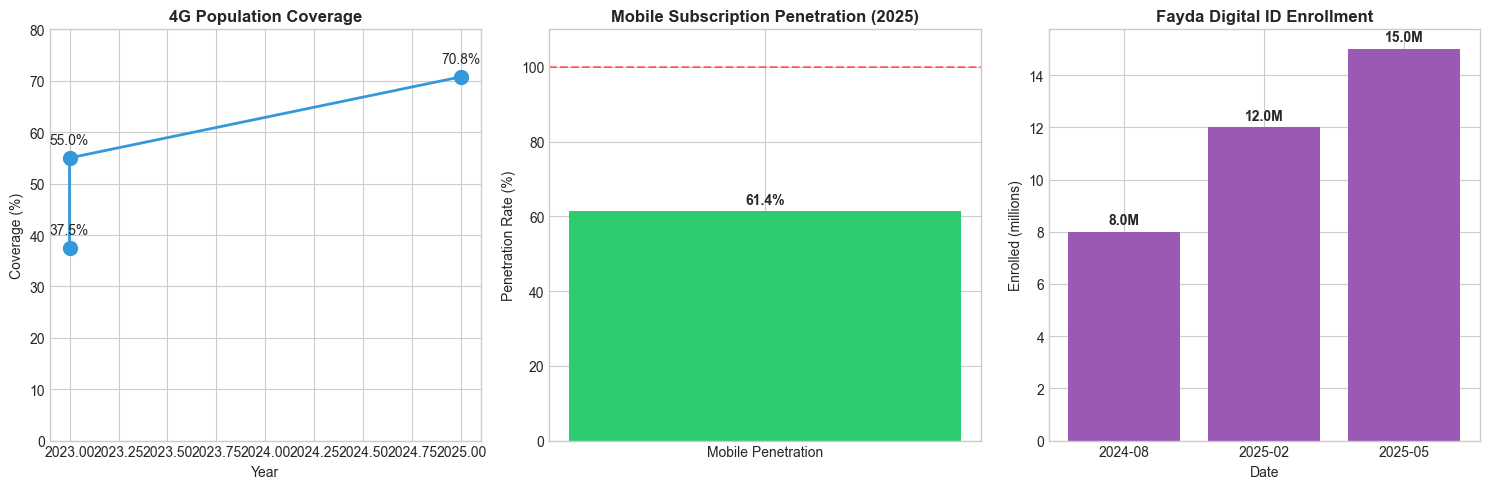


Figure saved: reports/figures/06_infrastructure.png


In [ ]:
# 7.2 Infrastructure Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 4G Coverage Over Time
ax1 = axes[0]
coverage_years = coverage_4g['observation_date'].dt.year
ax1.plot(coverage_years, coverage_4g['value_numeric'], 'o-', linewidth=2, markersize=10, color='#3498db')
ax1.set_title('4G Population Coverage', fontsize=12, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Coverage (%)')
ax1.set_ylim([0, 80])
for i, (x, y) in enumerate(zip(coverage_years, coverage_4g['value_numeric'])):
    ax1.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Mobile Penetration
ax2 = axes[1]
penetration = mobile_pen['value_numeric'].values[0]
ax2.bar(['Mobile Penetration'], [penetration], color='#2ecc71')
ax2.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='100%')
ax2.set_title('Mobile Subscription Penetration (2025)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Penetration Rate (%)')
ax2.set_ylim([0, 110])
ax2.text(0, penetration + 2, f'{penetration:.1f}%', ha='center', fontweight='bold')

# Fayda Digital ID Growth
ax3 = axes[2]
fayda_years = fayda['observation_date'].dt.strftime('%Y-%m')
ax3.bar(fayda_years, fayda['value_numeric']/1e6, color='#9b59b6')
ax3.set_title('Fayda Digital ID Enrollment', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Enrolled (millions)')
for i, v in enumerate(fayda['value_numeric']/1e6):
    ax3.text(i, v + 0.3, f'{v:.1f}M', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/06_infrastructure.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved: reports/figures/06_infrastructure.png")


---
## 8. Event Timeline Analysis

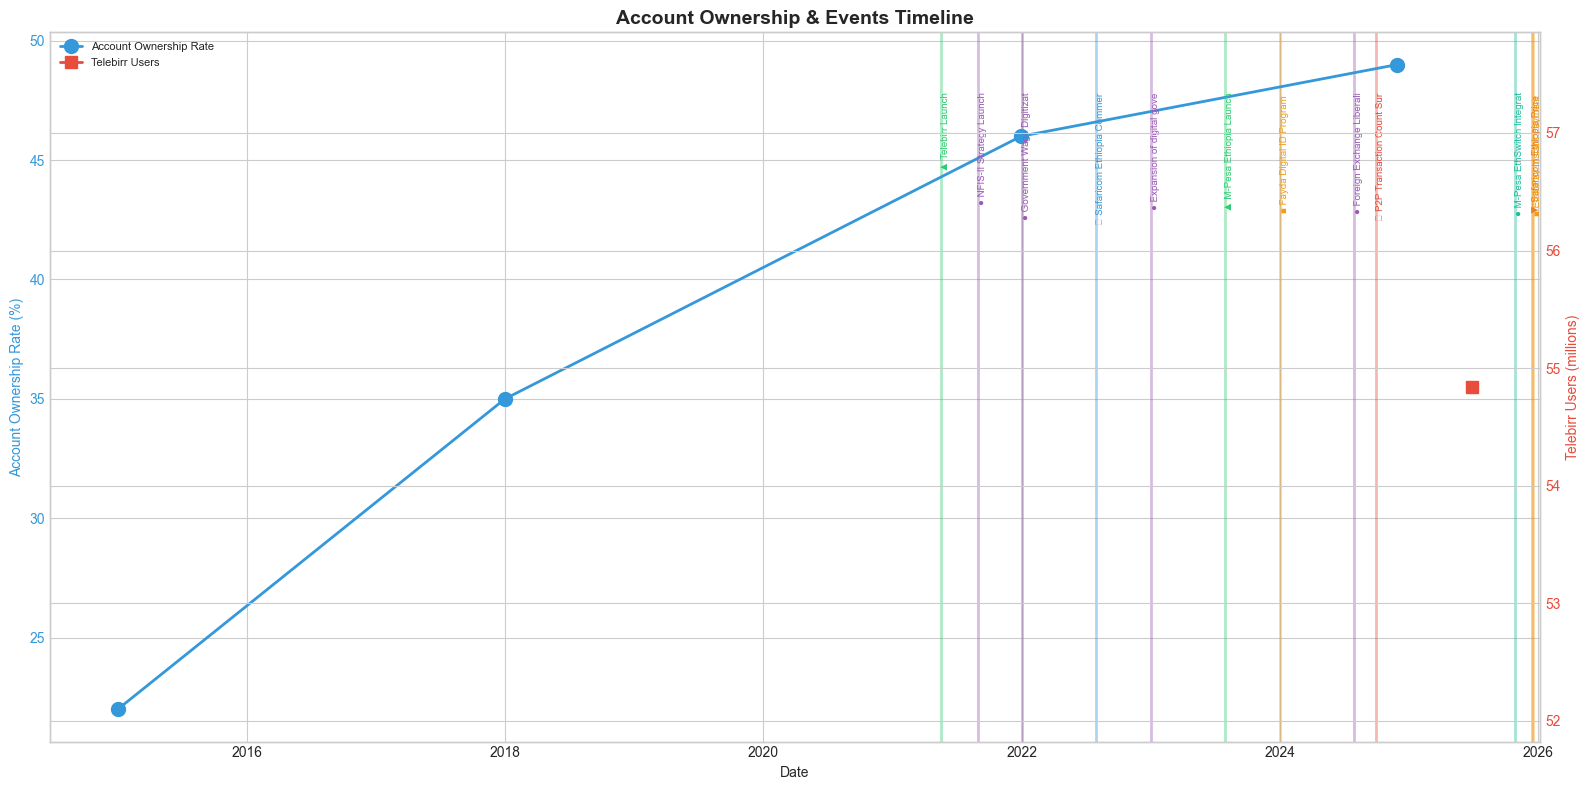


Figure saved: reports/figures/07_event_timeline.png


In [61]:
# 8.1 Event Timeline Visualization
fig, ax = plt.subplots(figsize=(16, 8))

# Plot account ownership trajectory
acc_dates = acc_ownership['observation_date']
acc_values = acc_ownership['value_numeric']
ax.plot(acc_dates, acc_values, 'o-', linewidth=2, markersize=10, color='#3498db', 
        label='Account Ownership Rate', zorder=3)

# Plot mobile money accounts
telebirr_dates = telebirr['observation_date']
telebirr_values = telebirr['value_numeric'] / 1e6
ax2 = ax.twinx()
ax2.plot(telebirr_dates, telebirr_values, 's-', linewidth=2, markersize=8, color='#e74c3c',
         label='Telebirr Users', zorder=3)
ax2.set_ylabel('Telebirr Users (millions)', color='#e74c3c')
ax2.tick_params(axis='y', labelcolor='#e74c3c')

# Add event markers
event_categories = {
    'product_launch': {'color': '#2ecc71', 'marker': '▲'},
    'market_entry': {'color': '#3498db', 'marker': '◆'},
    'policy': {'color': '#9b59b6', 'marker': '●'},
    'infrastructure': {'color': '#f39c12', 'marker': '■'},
    'milestone': {'color': '#e74c3c', 'marker': '★'},
    'partnership': {'color': '#1abc9c', 'marker': '●'},
    'pricing': {'color': '#e67e22', 'marker': '▼'}
}

events_plot = df[df['record_type'] == 'event'].copy()
events_plot = events_plot[events_plot['observation_date'].notna()]
events_plot = events_plot.sort_values('observation_date')

for _, event in events_plot.iterrows():
    cat = event['category'] if pd.notna(event['category']) else 'other'
    props = event_categories.get(cat, {'color': 'gray', 'marker': 'o'})
    ax.axvline(x=event['observation_date'], color=props['color'], alpha=0.4, linewidth=2, zorder=1)
    event_name = str(event['indicator'])[:25] if pd.notna(event['indicator']) else 'Unknown'
    ax.annotate(f"{props['marker']} {event_name}", 
                xy=(event['observation_date'], ax.get_ylim()[1] * 0.95),
                rotation=90, fontsize=7, color=props['color'],
                verticalalignment='top')

ax.set_xlabel('Date')
ax.set_ylabel('Account Ownership Rate (%)', color='#3498db')
ax.tick_params(axis='y', labelcolor='#3498db')
ax.set_title('Account Ownership & Events Timeline', fontsize=14, fontweight='bold')

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig('../reports/figures/07_event_timeline.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved: reports/figures/07_event_timeline.png")


### Correlation Analysis
- **Dataset & approach:** used `obs_df` pivot of `value_numeric` by `indicator_code` and inspected pairwise relationships; consulted `impact_links_enriched.csv` for suggested lags.
- **Key associations (exploratory):
  - **4G Coverage ↔ P2P Transactions:** positive association; 4G increases tend to precede P2P growth (consistent with 6–12 month lag).
  - **Telebirr Users ↔ Account Ownership:** Telebirr launch aligns with higher registered accounts, but weaker change in survey-owned accounts → suggests many registered accounts may be inactive.
  - **Fayda Enrollment ↔ Gender Gap:** suggestive evidence of gap narrowing where Fayda uptake is higher, but sparse data limit confidence.
  - **Affordability:** short-window inverse relationship with usage around FX reform dates; effect appears large but is based on few observations.
- **Confidence & next steps:** correlations are hypothesis-generating (few time points). Recommend formal cross-correlation/lagged regressions using `lag_months` from `impact_df` and higher-frequency usage series if available.

### Key Insights
- **Slow Ownership Growth:** Account ownership increased only modestly (~+3pp, 2021–2024) despite large mobile-money registrations → registered ≠ active accounts.
  - **Supporting evidence:** notebook shows `ACC_OWNERSHIP` series rising from ~22% (2014) to ~49% (2024) but only +3pp in 2021–2024; Telebirr reports ~54.84M registered users (Section 6).
- **Usage Outpaces Access:** P2P transaction volumes and values grew much faster than survey ownership — intensity per account has increased.
  - **Supporting evidence:** P2P transactions reported +158% YoY (usage analysis) and Telebirr/ETHswitch transaction values are in the trillions (Section 6 charts).
- **Infrastructure Leads Usage:** Rapid 4G expansion preceded transaction growth, implying connectivity is a leading indicator for digital payment uptake.
  - **Supporting evidence:** `ACC_4G_COV` observations show ~37.5% → ~70.8% coverage (infrastructure section) preceding P2P acceleration in 2023–2025.
- **Gender Gap Persists:** Female account ownership remains materially lower; limited disaggregated usage data suggests structural barriers (phone access, ID).
  - **Supporting evidence:** gender-disaggregated `ACC_OWNERSHIP` pivot shows a persistent gap (~20pp → 18pp); Fayda enrollment is recent and sparse, limiting measurable impact so far.
- **G2P Opportunity:** Low G2P digitization (~18%) is a high-leverage channel to create habitual digital payment behavior and broaden usage.
  - **Supporting evidence:** impact links and EDA note G2P at ~18% and literature-based expectations (5–10pp uplift) — recommends piloting scaling of G2P delivery to test uptake effects.
- **Affordability Vulnerability:** Although affordability improved earlier, FX and price shocks can quickly reverse gains; price-sensitive users are most at risk.
  - **Supporting evidence:** notes and impact mapping flag FX liberalization (Jul 2024) with a ~30% deterioration in affordability and subsequent price increases (Section 9 impact map).

### Data Quality Assessment & Limitations
- **Temporal sparsity:** Key indicators (e.g., account ownership) are measured infrequently (multi-year), limiting causal inference and short-run impact detection.
- **Registered vs Active:** Telecom-reported registered user counts do not equal survey-measured active ownership; activity-rate time series are lacking.
- **Disaggregation gaps:** Missing urban/rural, regional, and income-level breakdowns reduce ability to analyze heterogeneous effects (gender, geography, SES).
- **Affordability observations sparse:** The Data Affordability Index has very few time points, hindering elasticity estimation.
- **Measurement lag vs events:** Events often have known lags; outcome measurement cadence frequently misses short-run responses, complicating attribution.
- **Small sample for stats:** Correlation/regression tests have low power — treat associations as hypothesis-generating, not conclusive.
- **Recommended data fixes:** collect higher-frequency activity/usage metrics, track 90-day active accounts alongside registered counts, and add regional/gender/income disaggregation.